In [307]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
import pandas as pd

import string
alphabet=list(string.ascii_lowercase)

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [308]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Read in Data

In [309]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
#case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'
#case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'

#case=ctrl

In [310]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-tun_cy5 gzCOBALT-tun_cy5


In [311]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5


In [312]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension


In [313]:
if not files:
    pp_path=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/annual_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)


['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [314]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [315]:
tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 

pp_dates='1988-2007'

c_files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension
print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5
['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [316]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [317]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

## Read in Observations

In [318]:
o2_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/O2_woa18_esm4grid.nc')
no3_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/nitrate_woa18_esm4grid.nc') # micromoles per kilogram, or micromol/L, equivalent to 1e-3 mol m-3
po4_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/phosphate_woa18_esm4grid.nc')
sio3_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/silicate_woa18_esm4grid.nc')
fe_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/iron_esm4grid.nc')

## Change Units on Model Data

In [319]:
ds = ds.isel(time=0)
o2_mod = ds.o2 * 1e3    # convert to mmoles m-3
no3_mod = ds.no3 * 1e3  # convert to mmoles m-3
po4_mod = ds.po4 * 1e3  # convert to mmoles m-3
sio4_mod = ds.si * 1e3  # convert to mmoles m-3
dfe_mod = ds.dfe * 1e6  # convert to micromoles m-3

# Transects

## Read in Cross Section

In [320]:
p18 = pd.read_csv('data/transects/P18_fixed.csv')

In [321]:
p18 = p18.sort_values(by='LATITUDE')
p18

,LATITUDE,LONGITUDE
174,-69.4407,-110
173,-68.9090,-110
172,-68.3328,-110
171,-67.7502,-110
170,-67.2505,-110
...,...,...
4,22.4998,-110
3,22.6998,-110
2,22.7990,-110
1,22.8672,-110


In [ ]:
np.min(p18.LATITUDE.values)

In [ ]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

ax.add_feature(cartopy.feature.LAND, zorder=0)
ax.plot(p18.LONGITUDE.values, p18.LATITUDE.values, transform=ccrs.PlateCarree())

# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

#plt.title('Bottom oxygen consumption, (mmol O$_2$ m$^{-2}$ d$^{-1}$)\nJorgensen obs product', fontsize=14)
#plt.savefig('plots/Obs_Bottom_Oxygen_Consumption.png', dpi=300, bbox_inches='tight')

## Extract Model

In [323]:
ds

<xarray.Dataset>
Dimensions:       (xh: 720, yh: 576, z_l: 35, z_i: 36, nv: 2)
Coordinates:
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
    time          object 1998-01-01 00:00:00
  * nv            (nv) float64 1.0 2.0
Data variables: (12/46)
    volcello      (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    dissic        (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    dissoc        (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    phyc          (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    zooc          (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    bacc          (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    ...            ...
    co3satarag    (z_l, yh, xh) float32 dask.array<chunksize=(35, 576, 720), meta=np.ndarray>
    time_bnds     (nv) timedelta64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    average_T1    datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_T2    datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_DT    timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    depth_levels  (z_l) float64 5.0 10.0 10.0 15.0 ... 500.0 500.0 500.0 500.0
Attributes:
    filename:          ocean_cobalt_omip_tracers_year_z.1988-1992.ann.nc
    title:             OM4p5_CORE2_IAF_gzCOBALT-tun_cy5
    associated_files:  areacello: 19880101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double
    history:           Sat Sep 24 13:05:26 2022: ncra -O /archive/Jessica.Luo...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [324]:
ds_trans = ds.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest')

In [325]:
# Calculate N*
N_star_mod = no3_mod - 16.0*po4_mod

In [326]:
o2_mod_trans = o2_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
no3_mod_trans = no3_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
po4_mod_trans = po4_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
sio4_mod_trans = sio4_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
dfe_mod_trans = dfe_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
N_star_mod_trans = N_star_mod.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values

## Extract Observations

In [327]:
# Calculate N*
N_star_obs = no3_obs['nitrate_woa18'] - 16.0*po4_obs['phosphate_woa18']

In [328]:
o2_obs_trans = o2_obs['O2_woa18'].sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
no3_obs_trans = no3_obs['nitrate_woa18'].sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
po4_obs_trans = po4_obs['phosphate_woa18'].sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
sio3_obs_trans = sio3_obs['silicate_woa18'].sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
fe_obs_trans = fe_obs['iron'].sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values
N_star_obs_trans = N_star_obs.sel(xh=p18.LONGITUDE.values[0], yh=p18.LATITUDE.values, method='nearest').values

# Evaluate Skill Metrics

In [329]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [330]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [331]:
# Oxygen
X=o2_mod_trans.flatten()
Y=o2_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_o2 = X[mask] - Y[mask]
res2_o2 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_o2 = stats.skew(res1_o2)
skew2_o2 = stats.skew(res2_o2)
res_o2 = res1_o2
r_o2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_o2 = rmse_diffs(res_o2)
bias_o2 = np.mean(res_o2)

In [332]:
# Nitrate
X=no3_mod_trans.flatten()
Y=no3_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_no3 = X[mask] - Y[mask]
res2_no3 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_no3 = stats.skew(res1_no3)
skew2_no3 = stats.skew(res2_no3)
res_no3 = res1_no3
r_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_no3 = rmse_diffs(res_no3)
bias_no3 = np.mean(res_no3)

In [333]:
# Phosphate
X=po4_mod_trans.flatten()
Y=po4_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_po4 = X[mask] - Y[mask]
res2_po4 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_po4 = stats.skew(res1_po4)
skew2_po4 = stats.skew(res2_po4)
res_po4 = res1_po4
r_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_po4 = rmse_diffs(res_po4)
bias_po4 = np.mean(res_po4)

In [334]:
# Silicate
X=sio4_mod_trans.flatten()
Y=sio3_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_sio4 = X[mask] - Y[mask]
res2_sio4 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_sio4 = stats.skew(res1_sio4)
skew2_sio4 = stats.skew(res2_sio4)
res_sio4 = res1_sio4
r_sio4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_sio4 = rmse_diffs(res_sio4)
bias_sio4 = np.mean(res_sio4)

In [335]:
# N*
X=N_star_mod_trans.flatten()
Y=N_star_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_N_star = X[mask] - Y[mask]
res2_N_star = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_N_star = stats.skew(res1_N_star)
skew2_N_star = stats.skew(res2_N_star)
res_N_star = res1_N_star
r_N_star = stats.pearsonr(X[mask],Y[mask])[0]
rmse_N_star = rmse_diffs(res_N_star)
bias_N_star = np.mean(res_N_star)

In [336]:
## IRON
## TO-DO

# Plot

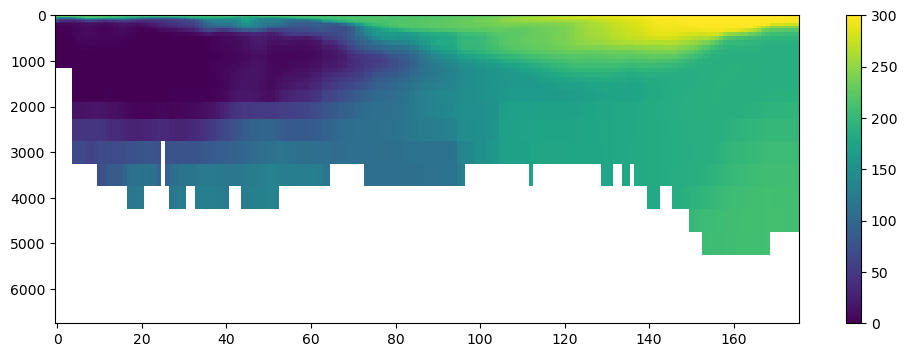

In [337]:
plt.figure(figsize=(12,4))
plt.pcolormesh(p18.index.values, ds.z_l.values, o2_mod_trans,vmax=300,vmin=0)
plt.gca().invert_yaxis()
plt.colorbar()

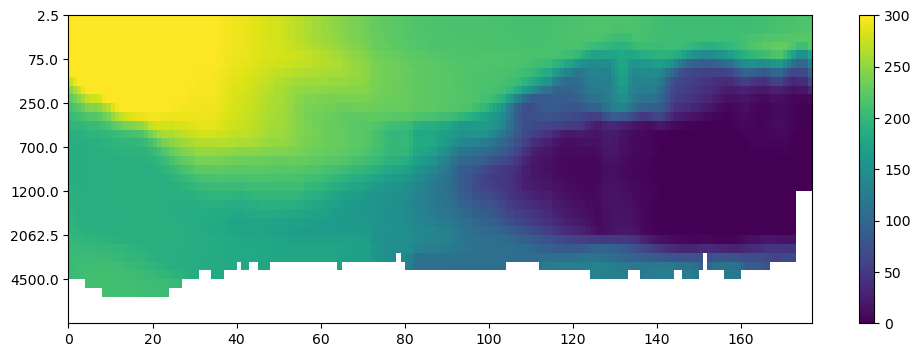

In [338]:
plt.figure(figsize=(12,4))
plt.pcolormesh(o2_mod_trans,vmax=300,vmin=0)
plt.gca().invert_yaxis()
plt.yticks(ticks=[0,5,10,15,20,25,30],labels=ds.z_l.values[[0,5,10,15,20,25,30]])
plt.colorbar()

In [339]:
xtick_ind = [20, 56, 91, 132, 168];
xtick_labels = ['60S','40S','20S','0','20N']

In [340]:
p18.index.values.sort()

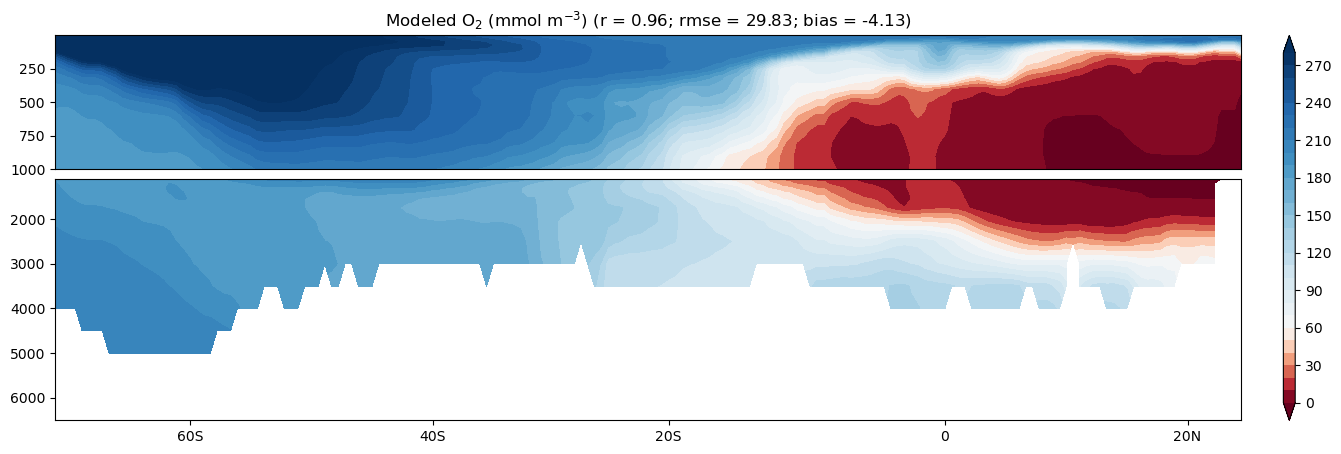

In [341]:
plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.07, height_ratios=(1,1.8), width_ratios=(1,0.01))

cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs[0,0])
field = o2_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')', 
             fontsize=12)

ax = plt.subplot(gs[1,0])
field = o2_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)

cb = plt.colorbar(cs,
    cax=plt.subplot(gs[:,-1]),
    orientation='vertical')

plt.tight_layout()

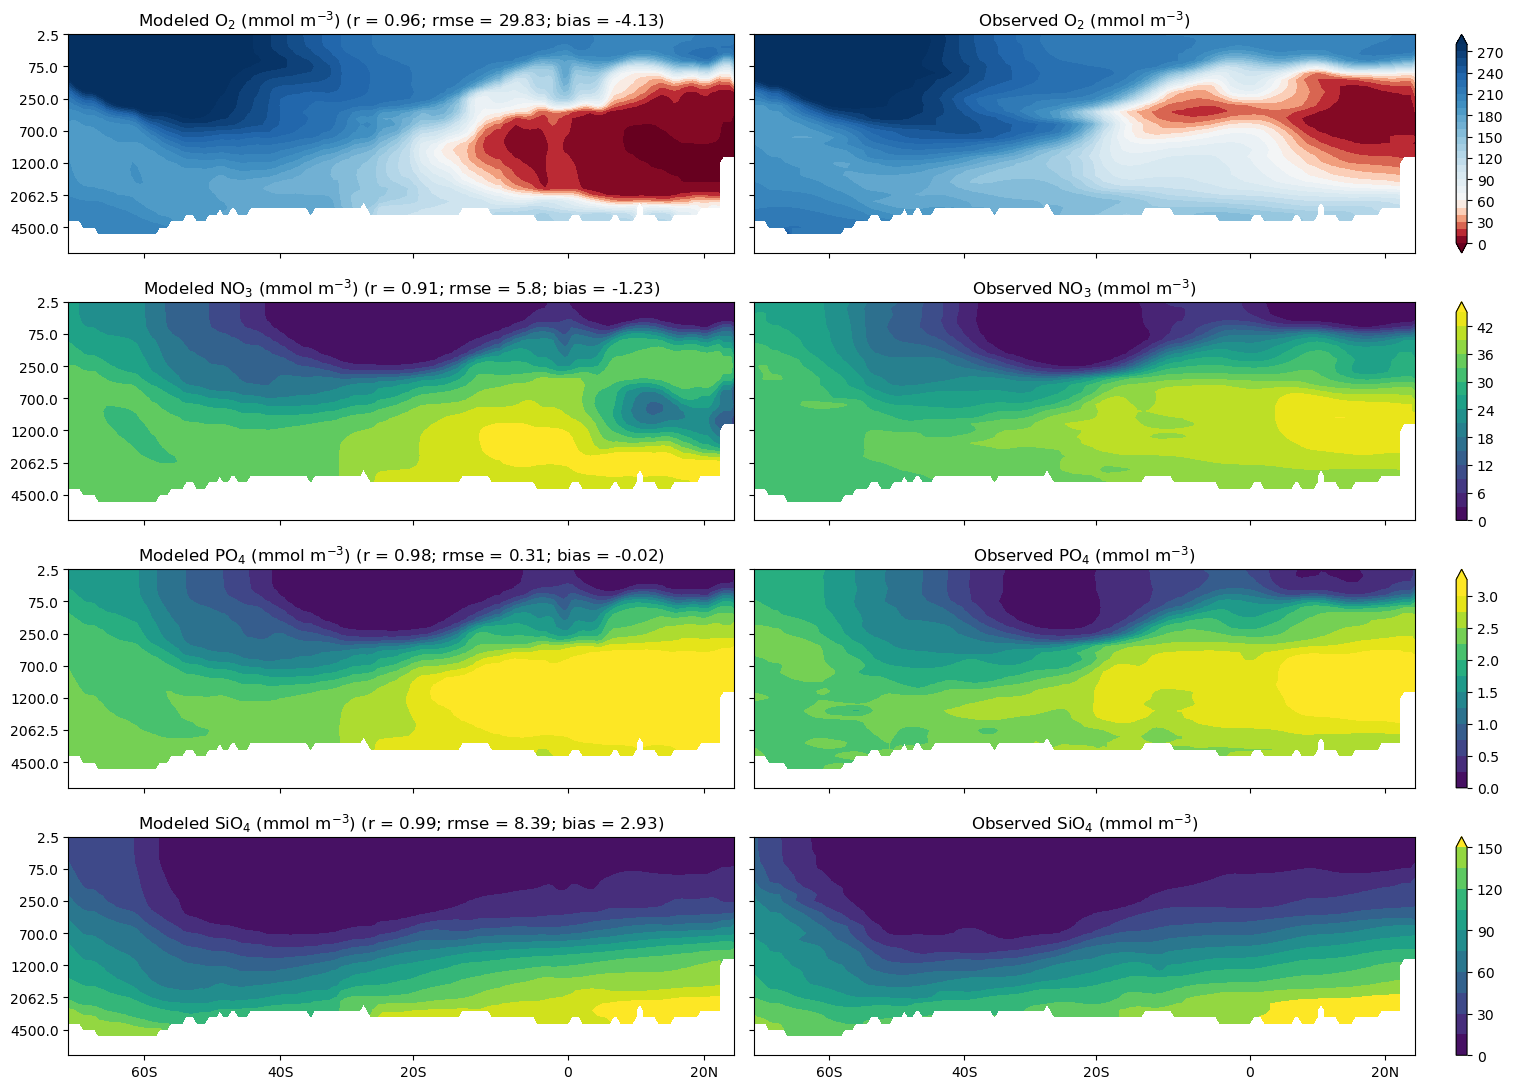

In [342]:
plt.figure(figsize=(16,11))
gs=gridspec.GridSpec(4,2, width_ratios=[1,1.24])

ax={};cs={}

###########################################################################
# oxygen                                                                  #
###########################################################################
cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0])
cs[i]=plt.contourf(o2_mod_trans,norm=MidpointNormalize(midpoint=60.), extend='both', levels=levels, cmap='RdBu')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')')

i=1
ax[i]=plt.subplot(gs[0,1])
cs[i]=plt.contourf(o2_obs_trans,norm=MidpointNormalize(midpoint=60.), extend='both', levels=levels, cmap='RdBu')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
ax[i].set_title('Observed O$_2$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# nitrate                                                                 #
###########################################################################
i=2
ax[i]=plt.subplot(gs[1,0])
cs[i]=plt.contourf(no3_mod_trans,levels=15,vmax=45,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled NO$_3$ (mmol m$^{-3}$) (r = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)) + ')')

i=3
ax[i]=plt.subplot(gs[1,1])
cs[i]=plt.contourf(no3_obs_trans,levels=15,vmax=45,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
ax[i].set_title('Observed NO$_3$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# phosphate                                                               #
###########################################################################

i=4
ax[i]=plt.subplot(gs[2,0])
cs[i]=plt.contourf(po4_mod_trans,levels=15,vmax=3,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled PO$_4$ (mmol m$^{-3}$) (r = ' + str(np.round(r_po4,2)) + \
                 '; rmse = ' + str(np.round(rmse_po4,2)) + \
                 '; bias = ' + str(np.round(bias_po4,2)) + ')')

i=5
ax[i]=plt.subplot(gs[2,1])
cs[i]=plt.contourf(po4_obs_trans,levels=15,vmax=3,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
ax[i].set_title('Observed PO$_4$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# silicate                                                                #
###########################################################################

i=6
ax[i]=plt.subplot(gs[3,0])
cs[i]=plt.contourf(sio4_mod_trans,levels=15,vmax=170,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled SiO$_4$ (mmol m$^{-3}$) (r = ' + str(np.round(r_sio4,2)) + \
                 '; rmse = ' + str(np.round(rmse_sio4,2)) + \
                 '; bias = ' + str(np.round(bias_sio4,2))+')')

i=7
ax[i]=plt.subplot(gs[3,1])
cs[i]=plt.contourf(sio3_obs_trans,levels=15,vmax=170,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
ax[i].set_title('Observed SiO$_4$ (mmol m$^{-3}$)')
cbar=plt.colorbar()

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Nutrient_CrossSection_P18.png', dpi=300, bbox_inches='tight')

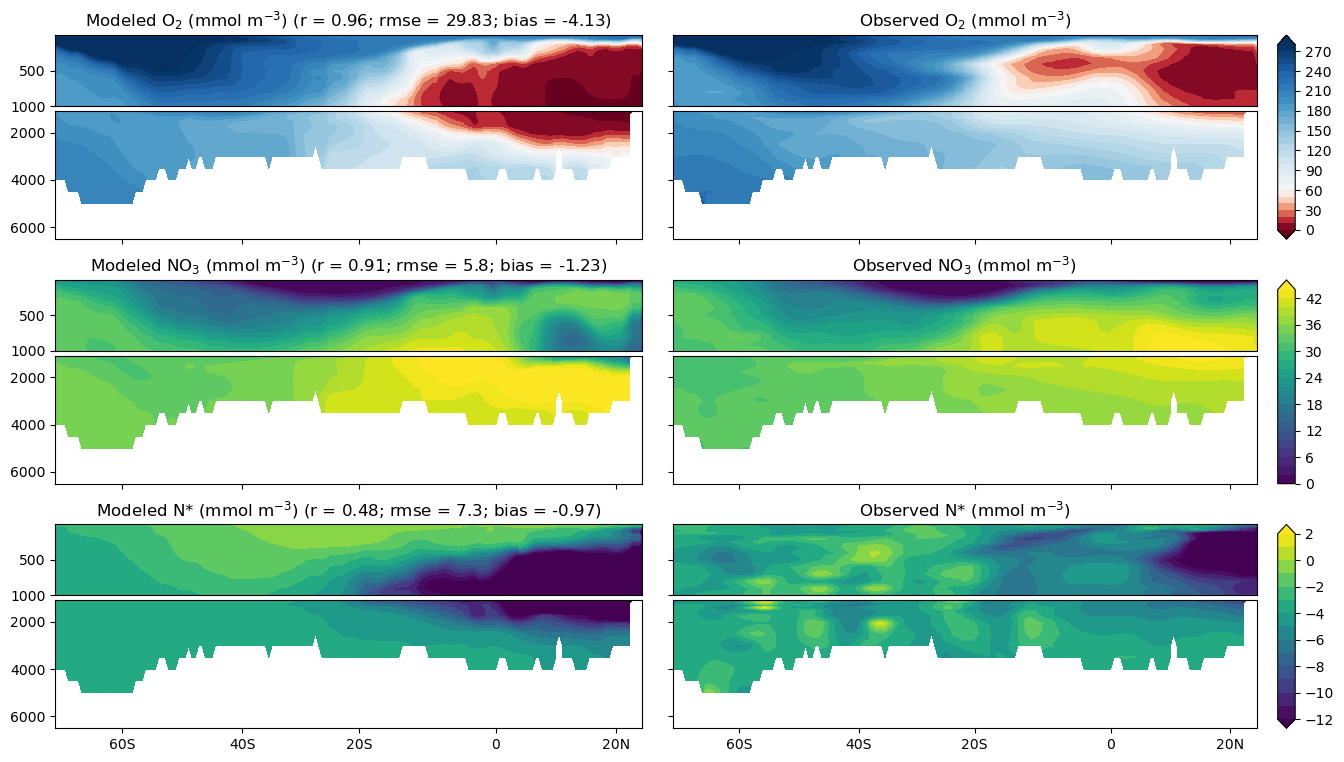

In [343]:
plt.figure(figsize=(16,9))
gs=gridspec.GridSpec(3,2, width_ratios=[1,1.06], wspace=0.05, hspace=0.2)

###########################################################################
# oxygen from model                                                       #
###########################################################################
gs00 = gs[0,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs00[0,0])
field = o2_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')', 
             fontsize=12)

ax = plt.subplot(gs00[1,0])
field = o2_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

###########################################################################
# oxygen from obs                                                         #
###########################################################################
gs01 = gs[0,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs01[0,0])
field = o2_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed O$_2$ (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs01[1,0])
field = o2_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs01[:,-1]),
    orientation='vertical')


###########################################################################
# nitrate from model                                                      #
###########################################################################
gs10 = gs[1,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin=0; cmax=45; cint=2
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs10[0,0])
field = no3_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled NO$_3$ (mmol m$^{-3}$) (r = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs10[1,0])
field = no3_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

###########################################################################
# nitrate from obs                                                        #
###########################################################################
gs11 = gs[1,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs11[0,0])
field = no3_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed NO$_3$ (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs11[1,0])
field = no3_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs11[:,-1]),
    orientation='vertical')


###########################################################################
# N* from model                                                           #
###########################################################################
gs20 = gs[2,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin = -12; cmax = 3; cint = 1
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs20[0,0])
field = N_star_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled N* (mmol m$^{-3}$) (r = ' + str(np.round(r_N_star,2)) + \
                 '; rmse = ' + str(np.round(rmse_N_star,2)) + \
                 '; bias = ' + str(np.round(bias_N_star,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs20[1,0])
field = N_star_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)

###########################################################################
# N* from obs                                                             #
###########################################################################
gs21 = gs[2,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs21[0,0])
field = N_star_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed N* (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs21[1,0])
field = N_star_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs21[:,-1]),
    orientation='vertical')

# plt.figtext(0.05, 0.02,'Atlantic',fontsize=12)
# plt.figtext(0.20, 0.02,'Southern',fontsize=12)
# plt.figtext(0.32, 0.02,'Pacific',fontsize=12)

# plt.figtext(0.48, 0.02,'Atlantic',fontsize=12)
# plt.figtext(0.63, 0.02,'Southern',fontsize=12)
# plt.figtext(0.75, 0.02,'Pacific',fontsize=12)

# plt.tight_layout(rect=(0,.025,1,1))
plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Nutrient_CrossSection_Split_P18.png', dpi=300, bbox_inches='tight')

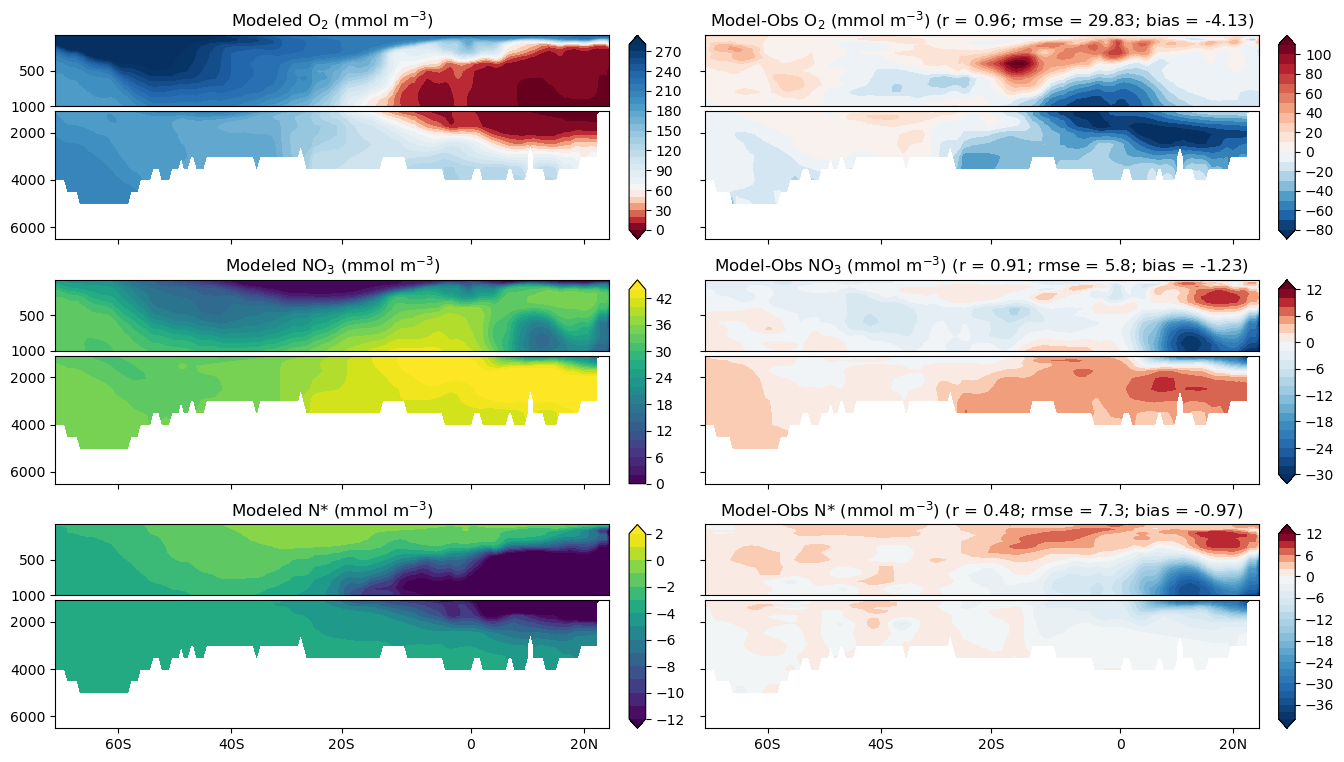

In [344]:
plt.figure(figsize=(16,9))
gs=gridspec.GridSpec(3,2, wspace=0.1, hspace=0.2)

###########################################################################
# oxygen from model                                                       #
###########################################################################
gs00 = gs[0,0].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs00[0,0])
field = o2_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled O$_2$ (mmol m$^{-3}$)', 
             fontsize=12)

ax = plt.subplot(gs00[1,0])
field = o2_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='both', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs00[:,-1]),
    orientation='vertical')

###########################################################################
# oxygen, model-obs diff                                                  #
###########################################################################
gs01 = gs[0,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin=-80; cmax=120; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs01[0,0])
field = o2_mod_trans[0:19,:]-o2_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Model-Obs O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs01[1,0])
field = o2_mod_trans[19:,:]-o2_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs01[:,-1]),
    orientation='vertical')


###########################################################################
# nitrate from model                                                      #
###########################################################################
gs10 = gs[1,0].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin=0; cmax=45; cint=2
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs10[0,0])
field = no3_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled NO$_3$ (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs10[1,0])
field = no3_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs10[:,-1]),
    orientation='vertical')

###########################################################################
# nitrate, model-obs diff                                                 #
###########################################################################
gs11 = gs[1,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin=-30; cmax=14; cint=2
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs11[0,0])
field = no3_mod_trans[0:19,:]-no3_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Model-Obs NO$_3$ (mmol m$^{-3}$) (r = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs11[1,0])
field = no3_mod_trans[19:,:]-no3_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs11[:,-1]),
    orientation='vertical')


###########################################################################
# N* from model                                                           #
###########################################################################
gs20 = gs[2,0].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin = -12; cmax = 3; cint = 1
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs20[0,0])
field = N_star_mod_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled N* (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs20[1,0])
field = N_star_mod_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)

cb = plt.colorbar(cs,
    cax=plt.subplot(gs20[:,-1]),
    orientation='vertical')

###########################################################################
# N*, model-obs diff                                                      #
###########################################################################
gs21 = gs[2,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

cmin=-40; cmax=14; cint=2
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs21[0,0])
field = N_star_mod_trans[0:19,:]-N_star_obs_trans[0:19,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Model-Obs N* (mmol m$^{-3}$) (r = ' + str(np.round(r_N_star,2)) + \
                 '; rmse = ' + str(np.round(rmse_N_star,2)) + \
                 '; bias = ' + str(np.round(bias_N_star,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs21[1,0])
field = N_star_mod_trans[19:,:]-N_star_obs_trans[19:,:]
cs=plt.contourf(p18.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=0.), 
                extend='both', levels=levels, cmap='RdBu_r')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs21[:,-1]),
    orientation='vertical')

# plt.tight_layout(rect=(0,.025,1,1))
plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Nutrient_CrossSection_Diffs_Split_P18.png', dpi=300, bbox_inches='tight')